In [1]:
root_dir = _dh[0].replace('/notebooks', '')
import sys; sys.path.append(root_dir)
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import numpy as np
import tensorflow as tf
import pickle
from adversarial_robustness.cnns import *
from adversarial_robustness.neural_network import *
from adversarial_robustness.plot_helpers import *
from adversarial_robustness.datasets.svhn import *
from adversarial_robustness.utils import *
model_dir = root_dir + '/cached/models'

# FGSM and TGSM Robustness for CNNs on SVHN

## Load the dataset

In [8]:
dataset = SVHN(include_train=False)
Xt = dataset.Xt[:4000] # SVHN is bigger than the other datasets, so we'll limit its size even earlier
yt = dataset.onehot_yt[:4000] # (so the accuracy evaluations can run without GPUs)
dataset

SVHN Dataset, D=32, K=10, N=6000/6000/26032 train/valid/test

## Evaluate accuracy on normal examples

In [12]:
normal_cnn = SVHN_CNN()
normal_cnn.load(model_dir + '/svhn-normal-cnn.pkl')
normal_cnn_score = normal_cnn.score(Xt, yt)
normal_cnn_score

Accuracy: 92.67%
F1 Score: 0.9204

In [13]:
distilled_cnn = SVHN_CNN()
distilled_cnn.load(model_dir + '/svhn-distilled-cnn.pkl')
distilled_cnn_score = distilled_cnn.score(Xt, yt)
distilled_cnn_score

Accuracy: 92.17%
F1 Score: 0.9165

In [14]:
advtrain_cnn = SVHN_CNN()
advtrain_cnn.load(model_dir + '/svhn-advtrain-cnn.pkl')
advtrain_cnn_score = advtrain_cnn.score(Xt, yt)
advtrain_cnn_score

Accuracy: 92.70%
F1 Score: 0.9217

In [15]:
insensitive_cnn = SVHN_CNN()
insensitive_cnn.load(model_dir + '/svhn-insensitive-1000.0-cnn.pkl')
insensitive_cnn_score = insensitive_cnn.score(Xt, yt)
insensitive_cnn_score

Accuracy: 92.33%
F1 Score: 0.9166

In [17]:
doubleback_cnn = SVHN_CNN()
doubleback_cnn.load(model_dir + '/svhn-doubleback-10000.0-cnn.pkl')
doubleback_cnn_score = doubleback_cnn.score(Xt, yt)
doubleback_cnn_score

Accuracy: 88.33%
F1 Score: 0.8692

## Visualize input gradients

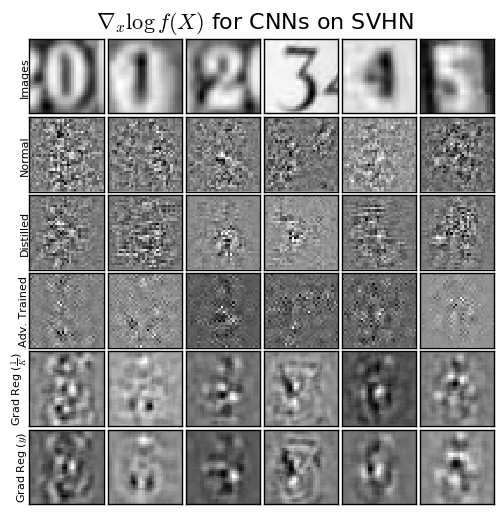

In [28]:
model_names = ['normal','distilled','advtrain','insensitive','doubleback']
models = [eval(m+'_cnn') for m in model_names]

# show gradients for different digits
show = [np.argwhere(dataset.yt==i)[1,0] for i in range(len(models)+1)]

plot_grads(dataset, models, model_names, show=show)
plt.gcf().suptitle(r'$\nabla_x \log\, f(X)$ for CNNs on {}'.format(dataset.name), fontsize=16, y=0.95)
plt.show()

## Compare prediction certainty

In [19]:
logps = {}
for m in model_names:
  logps[m] = eval(m+'_cnn_score').logps

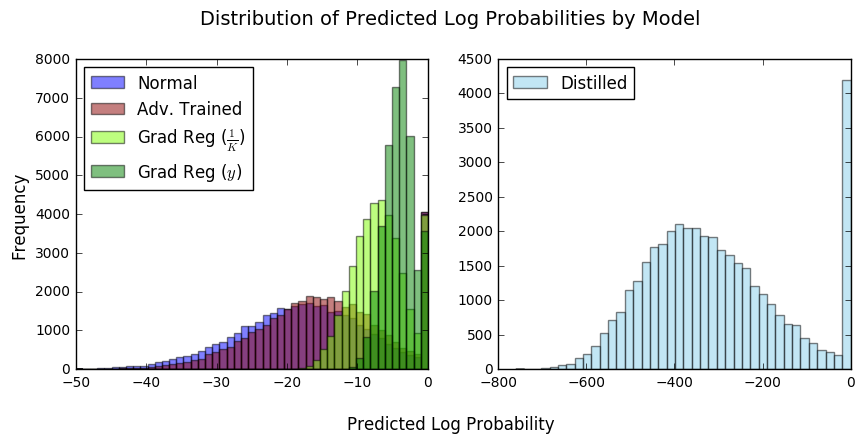

In [20]:
bins = np.linspace(-50, 0, 50)
plt.figure(figsize=(10,4)).suptitle('Distribution of Predicted Log Probabilities by Model', fontsize=14, y=1.025)
plt.subplot(121)
for m in model_names:
  if m != 'distilled':
    plt.hist(logps[m].flatten(), alpha=0.5, bins=bins, label=model_labels[m], color=model_colors[m])
plt.legend(loc='best')
plt.ylabel('Frequency', fontsize=12)
plt.xticks([-50,-40,-30,-20,-10,0])
plt.subplot(122)
plt.hist(logps['distilled'].flatten(), alpha=0.5, bins=40, label='Distilled', color='skyblue')
plt.legend(loc='upper left')
plt.xticks([-800,-600,-400,-200,0])
plt.figtext(0.5, 0.01, 'Predicted Log Probability', va='top', ha='center', fontsize=12)
plt.show()

## Compare Input Gradient L2 Norms

In [21]:
y1 = onehot((dataset.yt+1)%10, 10)

fgsm_grads = [
  net.batch_input_gradients(Xt, yt) for net in models]

tgsm_grads = [
  net.batch_input_gradients(Xt, y1) for net in models]

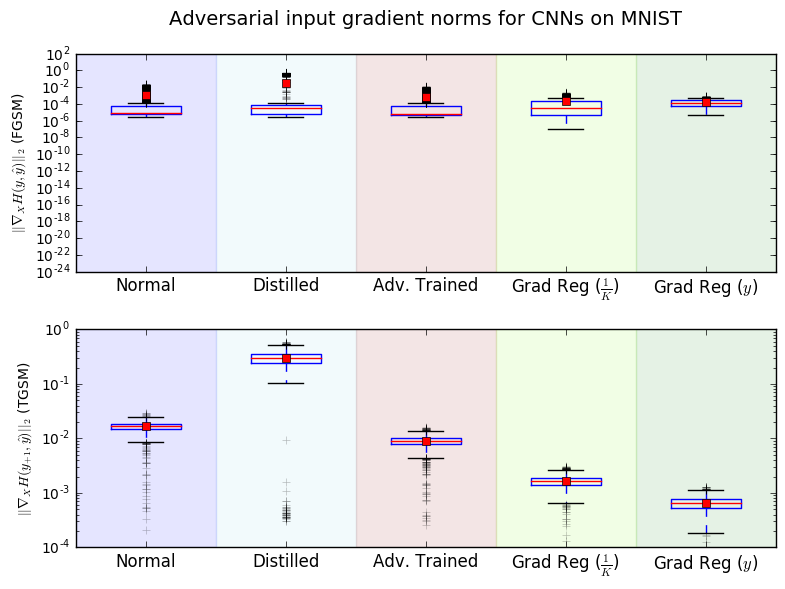

In [24]:
plt.figure(figsize=(8,6))
    
plt.subplot(211)
grad_size_boxplot(fgsm_grads, model_names)
plt.ylim(1e-24, 1e2)
plt.ylabel(r'$||\nabla_X H(y, \hat{y})||_2$ (FGSM)')

plt.title('Adversarial input gradient norms for CNNs on MNIST', fontsize=14, y=1.1)
    
plt.subplot(212)
grad_size_boxplot(tgsm_grads, model_names)
plt.ylim(1e-4, 1e0)
plt.ylabel(r"$||\nabla_X H(y_{+1}, \hat{y})||_2$ (TGSM)")

plt.tight_layout()
plt.show()

## Generate FGSM examples

In [29]:
limit = 256 # so this notebook runs quickly
fgsms = lazydict(lambda m:
          lazydict(lambda eps:
            np.clip(Xt + eps * np.sign(fgsm_grads[model_names.index(m)]),
                    Xt.min(),
                    Xt.max())[:limit]))

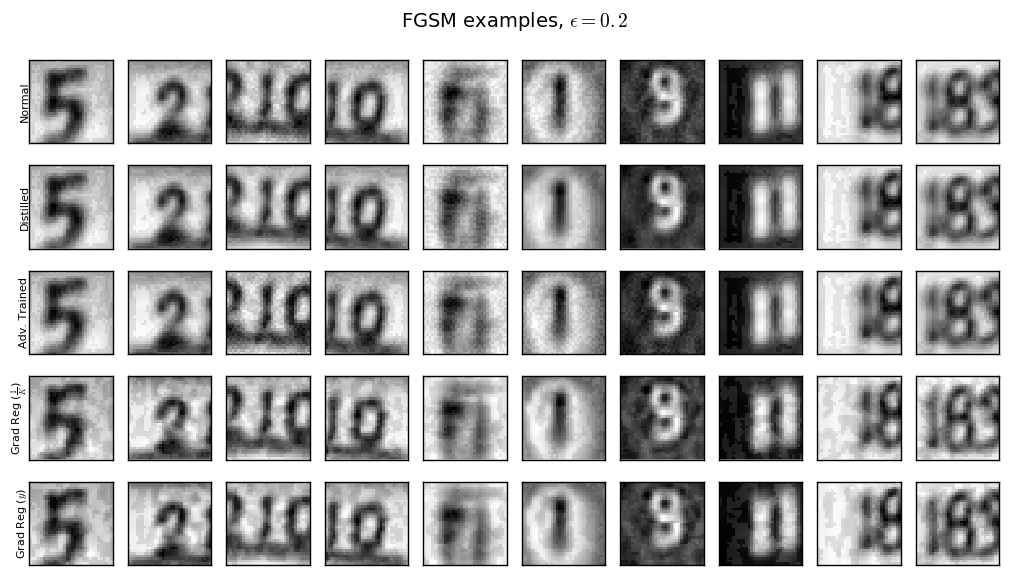

In [30]:
with figure_grid(len(models),10,rowheight=1.1, rowwidth=10) as g:
  g.title('FGSM examples, $\epsilon=0.2$')
  for m in model_names:
    for i in range(10):
      g.next()
      if i == 0: sidetext(model_labels[m])
      dataset.imshow_example(fgsms[m][0.2][i])

## Compare accuracy for every model vs. every other model's FGSM examples

In [31]:
fgsm_scores = {}
epses = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for model1 in model_names:
  cnn = eval(model1+'_cnn')
  with tf.Session() as sess:
    cnn.init(sess)
    for model2 in model_names:
      print('\n###################################################\n')
      print('Testing {} CNN against {} CNN FGSM examples'.format(model1, model2))
      fgsm_scores[(model1, model2)] = adversarial_grid(sess, cnn, fgsms[model2], yt[:limit], epses=epses)


###################################################

Testing normal CNN against normal CNN FGSM examples
ε=0 has accuracy 0.9140625
ε=0.1 has accuracy 0.62890625
ε=0.2 has accuracy 0.62890625
ε=0.3 has accuracy 0.62890625
ε=0.4 has accuracy 0.6015625
ε=0.5 has accuracy 0.54296875
ε=0.6 has accuracy 0.47265625
ε=0.7 has accuracy 0.375

###################################################

Testing normal CNN against distilled CNN FGSM examples
ε=0 has accuracy 0.9140625
ε=0.1 has accuracy 0.875
ε=0.2 has accuracy 0.84765625
ε=0.3 has accuracy 0.79296875
ε=0.4 has accuracy 0.734375
ε=0.5 has accuracy 0.60546875
ε=0.6 has accuracy 0.5234375
ε=0.7 has accuracy 0.421875

###################################################

Testing normal CNN against advtrain CNN FGSM examples
ε=0 has accuracy 0.9140625
ε=0.1 has accuracy 0.7734375
ε=0.2 has accuracy 0.703125
ε=0.3 has accuracy 0.65625
ε=0.4 has accuracy 0.62109375
ε=0.5 has accuracy 0.54296875
ε=0.6 has accuracy 0.46484375
ε=0.7 has accuracy

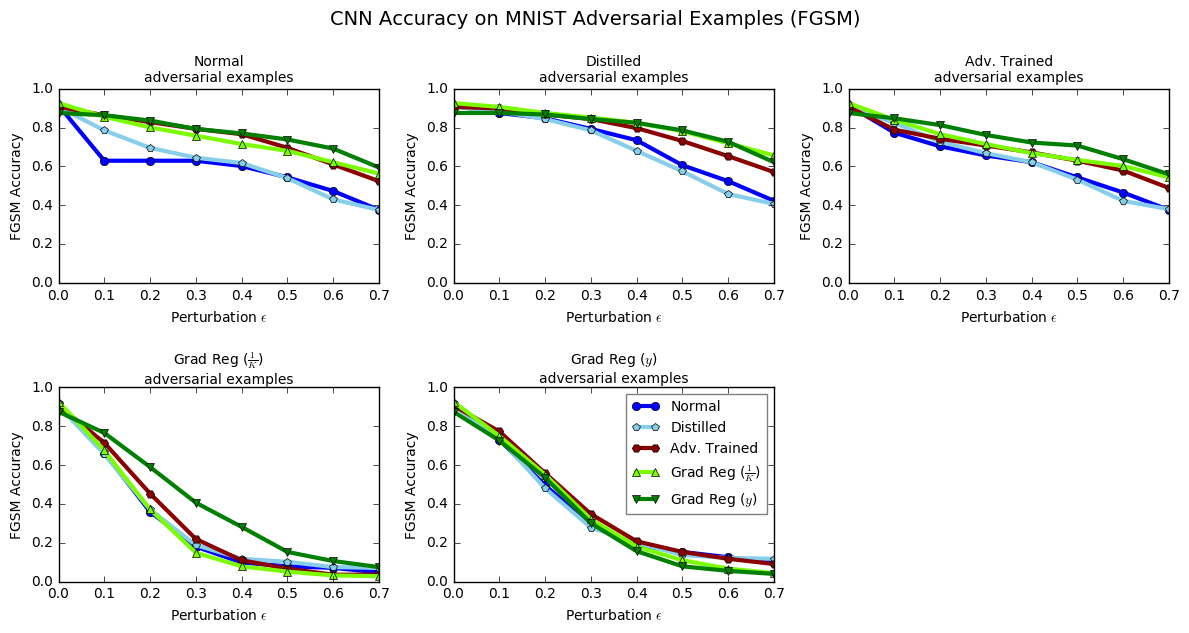

In [32]:
with figure_grid(2,3) as g:
  g.title('CNN Accuracy on MNIST Adversarial Examples (FGSM)')
  for model2 in model_names:
    g.next()
    plt.title('{}\nadversarial examples'.format(model_labels[model2]), fontsize=10)
    for model1 in model_names:
      model_scores = [fgsm_scores[(model1, model2)][1][eps] for eps in epses]
      plt.plot(epses, model_scores, lw=3,
               label=model_labels[model1],
               marker=model_markers[model1],
               color=model_colors[model1])
    plt.ylim(0,1)
    plt.ylabel('FGSM Accuracy')
    plt.xlabel('Perturbation $\epsilon$')
    if model2 == model_names[-1]:
      plt.legend(loc='best', fontsize=10, framealpha=0.5)

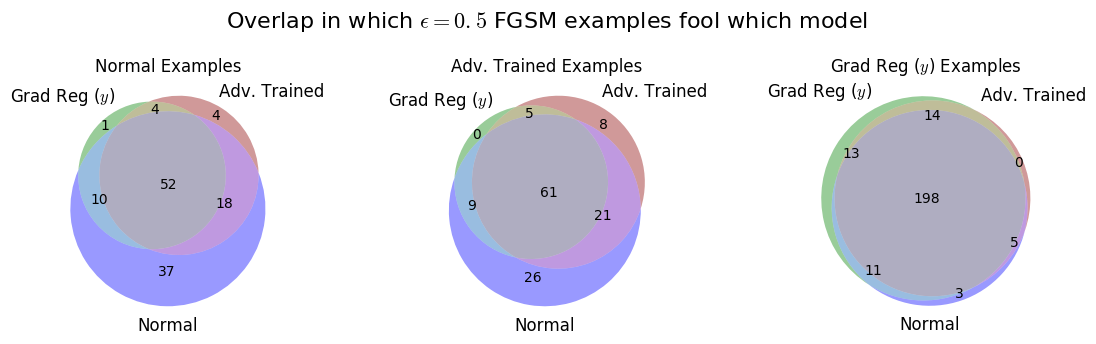

In [44]:
compare_misclassification_overlaps(fgsm_scores, yt, ['normal','advtrain','doubleback'], eps=0.5)
plt.gcf().suptitle('Overlap in which $\epsilon=0.5$ FGSM examples fool which model', y=1.1, fontsize=16)
plt.tight_layout()
plt.show()

## Generate TGSM examples

In [39]:
tgsms = lazydict(lambda m:
          lazydict(lambda eps:
            np.clip(Xt - eps * np.sign(tgsm_grads[model_names.index(m)]),
                    Xt.min(),
                    Xt.max())[:limit]))

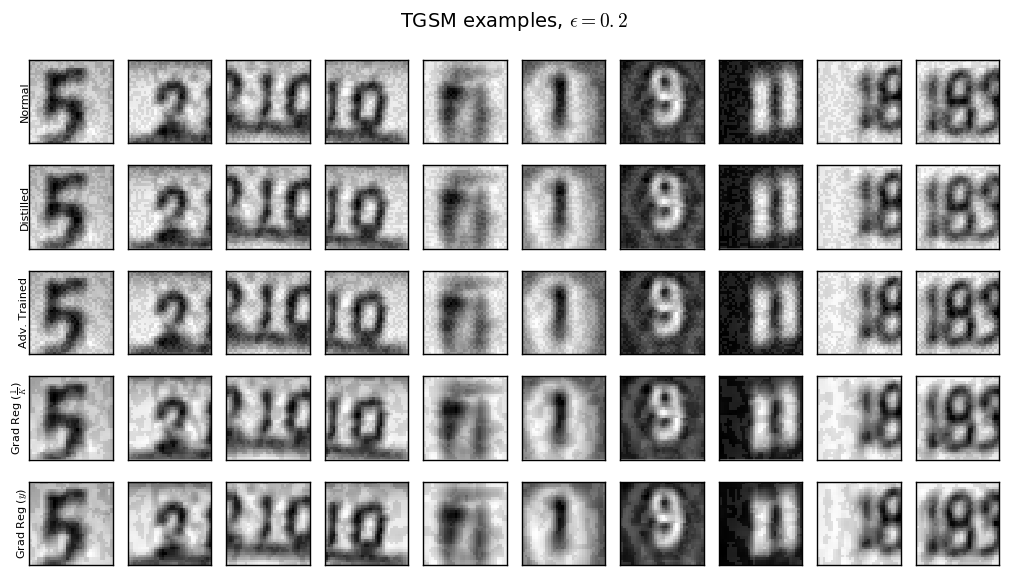

In [40]:
with figure_grid(len(models),10,rowheight=1.1, rowwidth=10) as g:
  g.title('TGSM examples, $\epsilon=0.2$')
  for model in model_names:
    for i in range(10):
      g.next()
      if i == 0: sidetext(model_labels[model])
      dataset.imshow_example(tgsms[model][0.2][i])

## Compare accuracy for every model vs. every other model's TGSM examples

In [41]:
tgsm_scores = {}
for model1 in model_names:
  cnn = eval(model1+'_cnn')
  with tf.Session() as sess:
    cnn.init(sess)
    for model2 in model_names:
      print('\n###################################################\n')
      print('Testing {} CNN against {} CNN TGSM examples'.format(model1, model2))
      tgsm_scores[(model1, model2)] = adversarial_grid(sess, cnn, tgsms[model2], yt[:limit], epses=epses)


###################################################

Testing normal CNN against normal CNN TGSM examples
ε=0 has accuracy 0.9140625
ε=0.1 has accuracy 0.40234375
ε=0.2 has accuracy 0.15625
ε=0.3 has accuracy 0.09765625
ε=0.4 has accuracy 0.07421875
ε=0.5 has accuracy 0.05078125
ε=0.6 has accuracy 0.02734375
ε=0.7 has accuracy 0.03125

###################################################

Testing normal CNN against distilled CNN TGSM examples
ε=0 has accuracy 0.9140625
ε=0.1 has accuracy 0.8203125
ε=0.2 has accuracy 0.69921875
ε=0.3 has accuracy 0.5703125
ε=0.4 has accuracy 0.4296875
ε=0.5 has accuracy 0.29296875
ε=0.6 has accuracy 0.22265625
ε=0.7 has accuracy 0.16015625

###################################################

Testing normal CNN against advtrain CNN TGSM examples
ε=0 has accuracy 0.9140625
ε=0.1 has accuracy 0.8359375
ε=0.2 has accuracy 0.7265625
ε=0.3 has accuracy 0.58984375
ε=0.4 has accuracy 0.47265625
ε=0.5 has accuracy 0.390625
ε=0.6 has accuracy 0.3125
ε=0.7 has acc

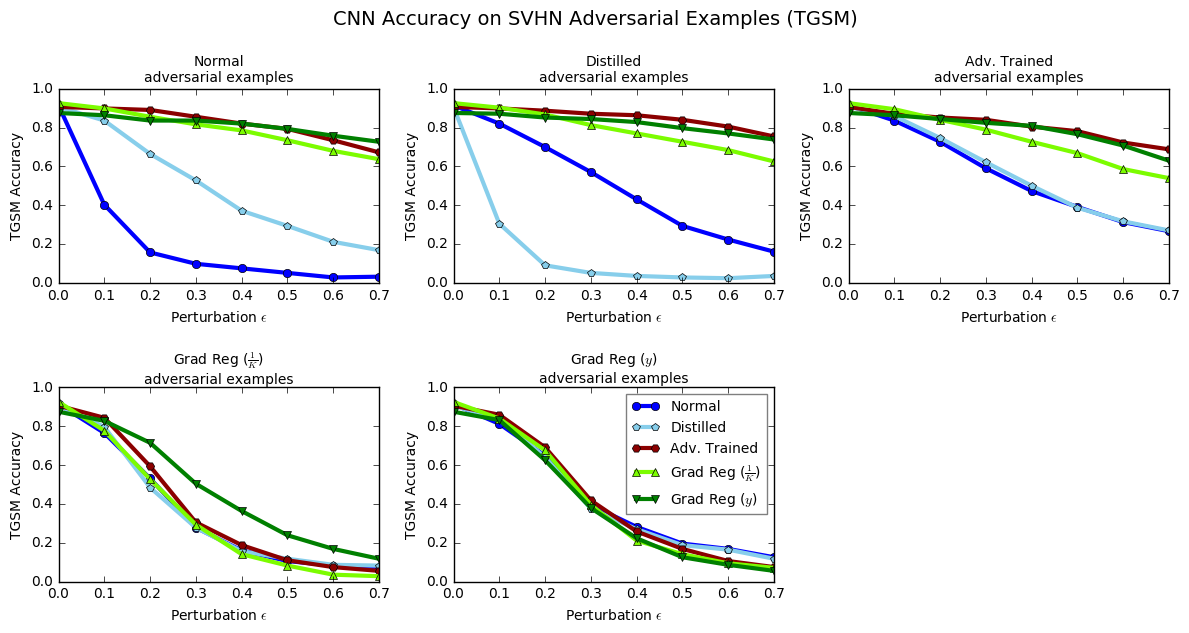

In [42]:
with figure_grid(2,3) as g:
  g.title('CNN Accuracy on {} Adversarial Examples (TGSM)'.format(dataset.name))
  for model2 in model_names:
    g.next()
    plt.title('{}\nadversarial examples'.format(model_labels[model2]), fontsize=10)
    for model1 in model_names:
      model_scores = [tgsm_scores[(model1, model2)][1][eps] for eps in epses]
      plt.plot(epses, model_scores, lw=3,
               label=model_labels[model1],
               marker=model_markers[model1],
               color=model_colors[model1])
    plt.ylim(0,1)
    plt.ylabel('TGSM Accuracy')
    plt.xlabel('Perturbation $\epsilon$')
    if model2 == model_names[-1]:
      plt.legend(loc='best', fontsize=10, framealpha=0.5)

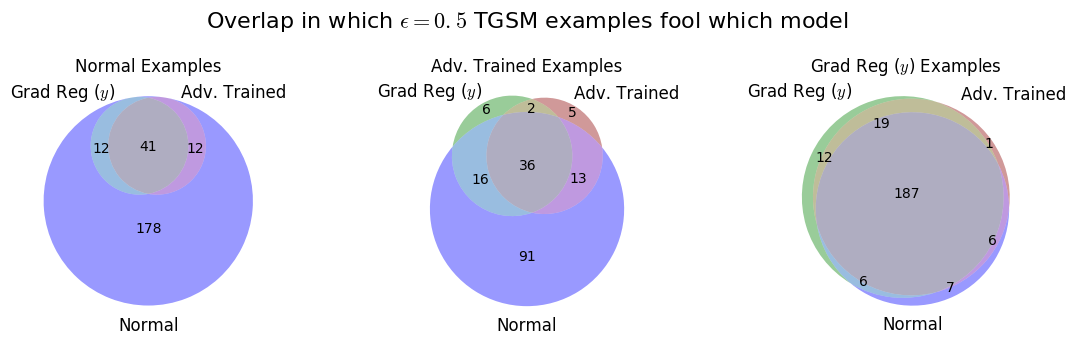

In [43]:
compare_misclassification_overlaps(tgsm_scores, yt, ['normal','advtrain','doubleback'], eps=0.5)
plt.gcf().suptitle('Overlap in which $\epsilon=0.5$ TGSM examples fool which model', y=1.1, fontsize=16)
plt.tight_layout()
plt.show()

## Iterated TGSM Confusion Matrices

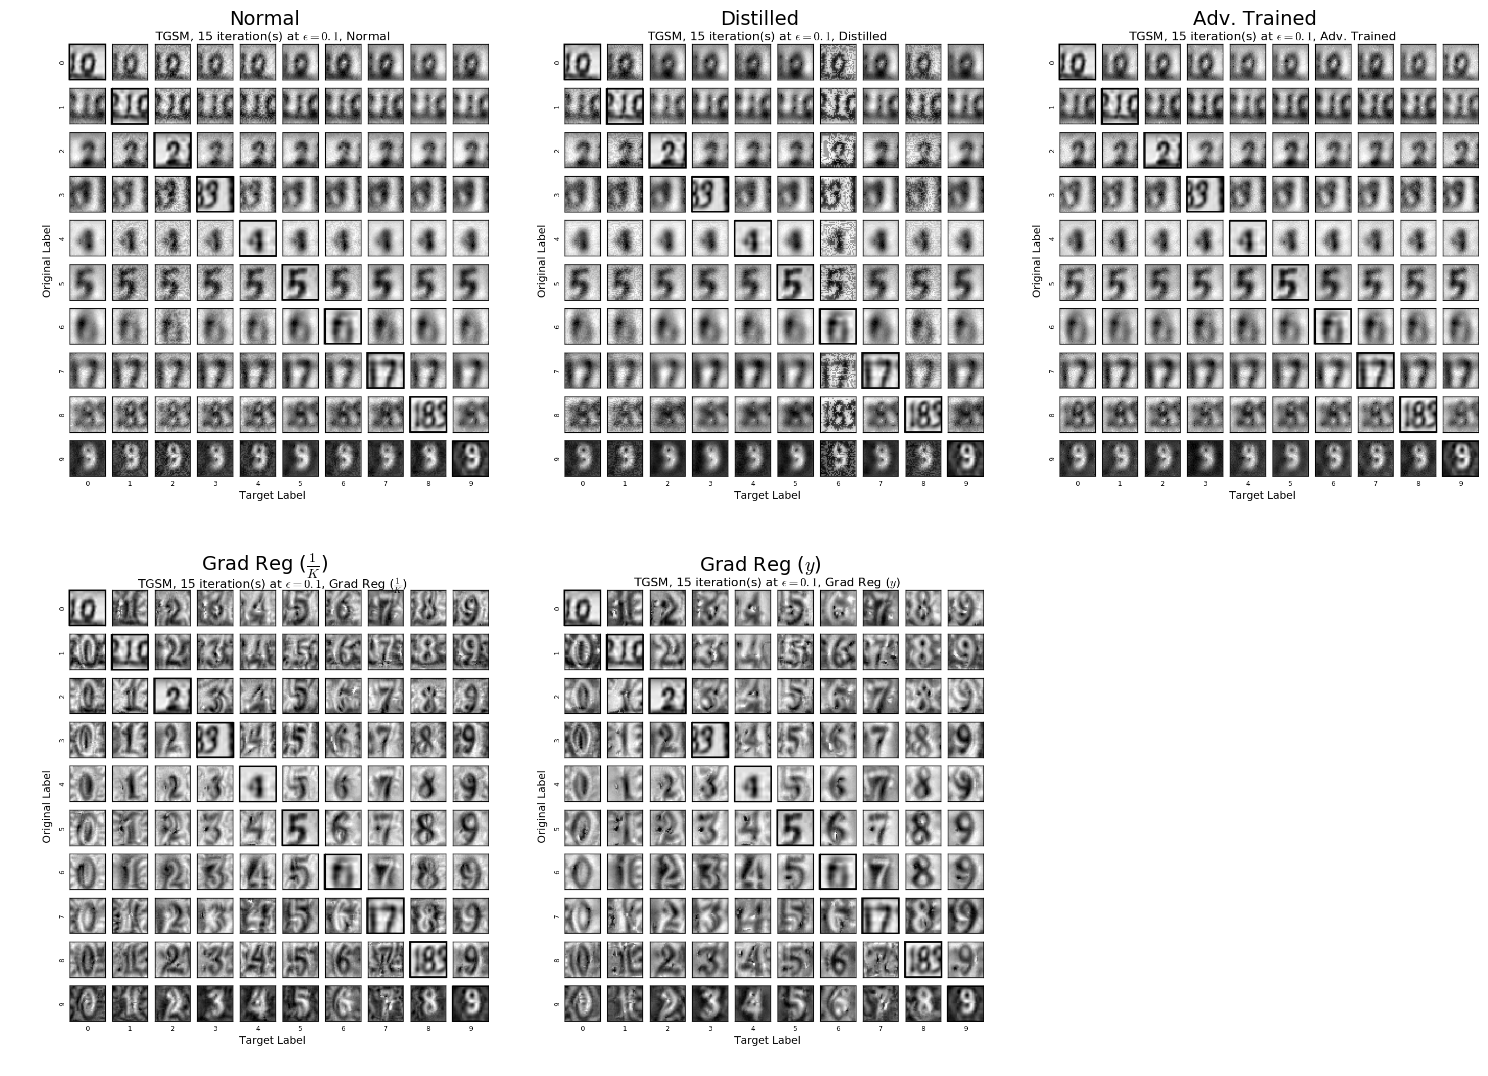

In [49]:
import matplotlib.image as mpimg
with figure_grid(2,3,rowwidth=15,rowheight=5.5) as g:
  for m in model_names:
    g.next()
    plt.title(model_labels[m], fontsize=14)
    img = mpimg.imread('../cached/tgsm/svhn/{}/tgsm-targetgrid-eps0pt1-epoch15.png'.format(m))
    plt.imshow(img)
    plt.axis('off')